
Cantidad de datos por año:
 Año
2004    1328
2008     707
2009     712
2012     709
2013    2081
2014    2120
2015     679
Name: count, dtype: int64

Usando 2014 como año base.

CSV limpio guardado como 'antofagasta_clean_final.csv'.


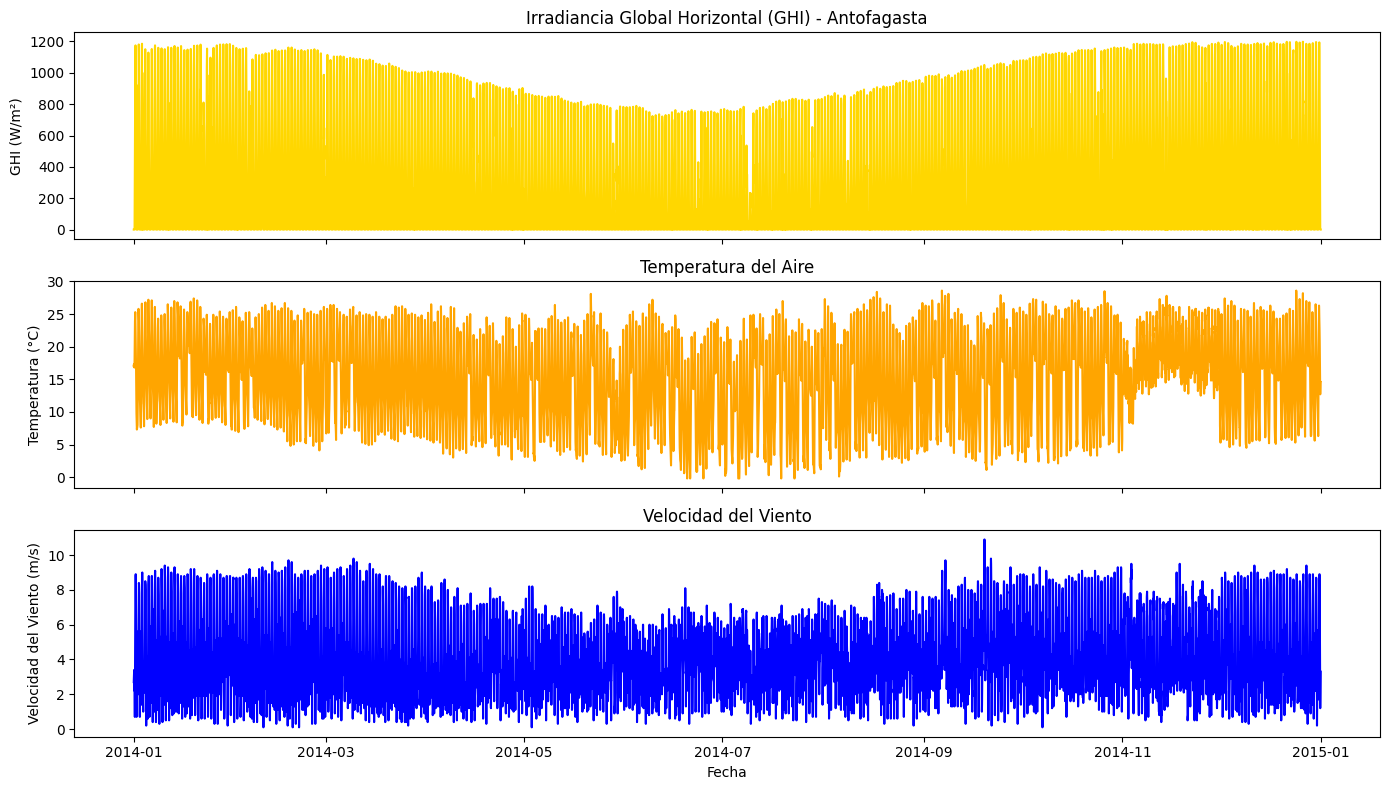

In [2]:
#=== Librerías necesarias ===
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar el CSV original ===
ruta_csv = 'antofagasta_dirty.csv'  # Asegúrate que esté en tu misma carpeta
df = pd.read_csv(ruta_csv)

# === 2. Crear columna de fecha a partir de Year, Month, Day, Hour, Minute ===
df['Fecha'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# === 3. Aplicar filtros de calidad física ===
df = df[
    (df['GHI'].between(0, 1200)) &
    (df['DNI'].between(0, 1200)) &
    (df['DHI'].between(0, 800)) &
    (df['Tdry'].between(-20, 60)) &
    (df['Wspd'].between(0, 30))
].copy()

# === 4. Agregar columna "Año" para analizar ===
df['Año'] = df['Fecha'].dt.year

# === 5. Mostrar cantidad de datos por año ===
conteo = df['Año'].value_counts().sort_index()
print("\nCantidad de datos por año:\n", conteo)

# === 6. Elegir año base (el que tenga más datos) ===
anio_base = conteo.idxmax()
print(f"\nUsando {anio_base} como año base.")

# === 7. Filtrar sólo datos del año base ===
df_base = df[df['Año'] == anio_base].copy()

# === 8. Rellenar huecos con datos de otros años ===
df_final = df_base.copy()

# Buscar fechas faltantes
fecha_inicio = pd.Timestamp(anio_base, 1, 1, 0, 0)
fecha_fin = pd.Timestamp(anio_base, 12, 31, 23, 0)
rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='h')

faltantes = rango_completo.difference(df_final['Fecha'])

# Intentar rellenar cada fecha faltante
for falta in faltantes:
    candidatos = df[
        (df['Fecha'].dt.month == falta.month) &
        (df['Fecha'].dt.day == falta.day) &
        (df['Fecha'].dt.hour == falta.hour)
    ]
    if not candidatos.empty:
        nuevo = candidatos.iloc[0].copy()
        nuevo['Fecha'] = falta
        nuevo['Año'] = anio_base
        df_final = pd.concat([df_final, nuevo.to_frame().T], ignore_index=True)

# Ordenar por fecha
df_final = df_final.sort_values('Fecha').reset_index(drop=True)

# === 9. Guardar CSV limpio ===
csv_salida = 'antofagasta_clean_final.csv'
df_final.to_csv(csv_salida, index=False)
print(f"\nCSV limpio guardado como '{csv_salida}'.")

# === 10. Graficar para verificar ===
fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

axs[0].plot(df_final['Fecha'], df_final['GHI'], color='gold')
axs[0].set_ylabel('GHI (W/m²)')
axs[0].set_title('Irradiancia Global Horizontal (GHI) - Antofagasta')

axs[1].plot(df_final['Fecha'], df_final['Tdry'], color='orange')
axs[1].set_ylabel('Temperatura (°C)')
axs[1].set_title('Temperatura del Aire')

axs[2].plot(df_final['Fecha'], df_final['Wspd'], color='blue')
axs[2].set_ylabel('Velocidad del Viento (m/s)')
axs[2].set_title('Velocidad del Viento')
axs[2].set_xlabel('Fecha')

plt.tight_layout()
plt.show()